# **Lead Scoring Case Study**

In [553]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## *Step 1: Data cleaning and preparation*

- Handling categorical variables
    - Mapping categorical variables to integers
    - Dummy variable creation
- Handling outliers & missing values

### Data Importing

In [554]:
# import Leads data
leads = pd.read_csv('data/Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [555]:
leads.shape

(9240, 37)

In [556]:
# check columns type
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [557]:

# Change name of some columns
leads.rename(columns={
    'How did you hear about X Education': 'source',
    'What is your current occupation': 'occupation',
    'What matters most to you in choosing a course': 'course_preference',
    'Total Time Spent on Website': 'total_time_on_website',
    'Receive More Updates About Our Courses': 'receive_updates',
    'Update me on Supply Chain Content': 'supply_chain_updates',
    'Get updates on DM Content': 'dm_content_updates',
    'I agree to pay the amount through cheque': 'cheque_payment_agreement',
    'A free copy of Mastering The Interview': 'free_copy_mastering_interview'
}, inplace=True)

### 1. Checking column with only one value (Unique value column)

In [558]:
uni_column = []
for i in leads.columns:
    if leads[i].unique().size ==1:
        uni_column.append(i)

In [559]:
# All columns with only one value.
uni_column

['Magazine',
 'receive_updates',
 'supply_chain_updates',
 'dm_content_updates',
 'cheque_payment_agreement']

- Take a look from above, there are some columns that contain only one value. (Single Unique Value)  
- Columns: **Magazine, receive_updates, supply_chain_updates, dm_content_updates, cheque_payment_agreement** 
 
=> Drop all these columns 

In [560]:
leads.drop(uni_column, axis=1, inplace= True)

In [561]:
leads.shape

(9240, 32)

### 2. Handling with missing values

In [562]:
# Checking the missing values
missing_rate = leads.isnull().sum()*100/leads.shape[0]

# Extract all columns containing missing values
missing_rate[missing_rate!=0].sort_values(ascending=False)

Lead Quality                   51.590909
Asymmetrique Profile Score     45.649351
Asymmetrique Activity Score    45.649351
Asymmetrique Profile Index     45.649351
Asymmetrique Activity Index    45.649351
Tags                           36.287879
Lead Profile                   29.318182
course_preference              29.318182
occupation                     29.112554
Country                        26.634199
source                         23.885281
Specialization                 15.562771
City                           15.367965
TotalVisits                     1.482684
Page Views Per Visit            1.482684
Last Activity                   1.114719
Lead Source                     0.389610
dtype: float64

#### Drop "Lead quality" column with > 50% missing values

In [563]:
leads["Lead Quality"].value_counts(normalize=True)

Lead Quality
Might be             0.348759
Not Sure             0.244131
High in Relevance    0.142410
Worst                0.134362
Low in Relevance     0.130338
Name: proportion, dtype: float64

- Data in this column has been not defined clearly. For example, it should be classified as **best**, **normal**, **worst** or **high**, **average**, **low**, but as this case, the data seems messy!  
=> This column will drop because of missing values and low quality

In [564]:
leads.drop(["Lead Quality"], axis=1, inplace = True)

#### Index and score columns with almost 50% missing value

In [565]:
asym_columns = ["Asymmetrique Profile Score", "Asymmetrique Activity Score", "Asymmetrique Profile Index", "Asymmetrique Activity Index"]

In [566]:
for i in asym_columns:
    leads[i].value_counts(normalize=True)

Asymmetrique Profile Score
15.0    0.350259
18.0    0.213262
16.0    0.119275
17.0    0.115293
20.0    0.061330
19.0    0.048785
14.0    0.045002
13.0    0.040621
12.0    0.004381
11.0    0.001792
Name: proportion, dtype: float64

Asymmetrique Activity Score
14.0    0.352648
15.0    0.257467
13.0    0.154321
16.0    0.092991
17.0    0.069494
12.0    0.039028
11.0    0.018917
10.0    0.011350
9.0     0.001792
18.0    0.000996
8.0     0.000796
7.0     0.000199
Name: proportion, dtype: float64

Asymmetrique Profile Index
02.Medium    0.555157
01.High      0.438670
03.Low       0.006173
Name: proportion, dtype: float64

Asymmetrique Activity Index
02.Medium    0.764436
01.High      0.163481
03.Low       0.072083
Name: proportion, dtype: float64

- In "Asymmetrique Profile Score" and "Asymmetrique Activity Score" columns, the difference between all values is not prominent.  
=> Imputing missing values with the median values.

In [567]:
leads["Asymmetrique Activity Score"].fillna(leads["Asymmetrique Activity Score"].median(), inplace = True)
leads["Asymmetrique Profile Score"].fillna(leads["Asymmetrique Profile Score"].median(), inplace = True)

- "Asymmetrique Profile Index" and "Asymmetrique Activity Index" columns are categorical and the proportions of values that occupy the highest part are over 50%.  
=> Replace missing values with the mode of the column.

In [568]:
leads["Asymmetrique Profile Index"].fillna(leads["Asymmetrique Profile Index"].mode()[0], inplace=True)
leads["Asymmetrique Activity Index"].fillna(leads["Asymmetrique Activity Index"].mode()[0], inplace=True)

#### All columns with moderate missing rates (15%-35%)

In [569]:
moderate_missing = ["Tags", "Lead Profile", "course_preference", "occupation", "Country",
"source", "Specialization", "City"]

In [570]:
for i in moderate_missing:
    leads[i].value_counts(normalize=True)

Tags
Will revert after reading the email                  0.351962
Ringing                                              0.204349
Interested in other courses                          0.087141
Already a student                                    0.078988
Closed by Horizzon                                   0.060812
switched off                                         0.040768
Busy                                                 0.031595
Lost to EINS                                         0.029727
Not doing further education                          0.024631
Interested  in full time MBA                         0.019874
Graduation in progress                               0.018855
invalid number                                       0.014099
Diploma holder (Not Eligible)                        0.010702
wrong number given                                   0.007984
opp hangup                                           0.005606
number not provided                                  0.004586
in 

Lead Profile
Select                         0.634819
Potential Lead                 0.246976
Other Leads                    0.074567
Student of SomeSchool          0.036901
Lateral Student                0.003675
Dual Specialization Student    0.003062
Name: proportion, dtype: float64

course_preference
Better Career Prospects      0.999541
Flexibility & Convenience    0.000306
Other                        0.000153
Name: proportion, dtype: float64

occupation
Unemployed              0.854962
Working Professional    0.107786
Student                 0.032061
Other                   0.002443
Housewife               0.001527
Businessman             0.001221
Name: proportion, dtype: float64

Country
India                   0.957663
United States           0.010178
United Arab Emirates    0.007818
Singapore               0.003540
Saudi Arabia            0.003098
United Kingdom          0.002213
Australia               0.001918
Qatar                   0.001475
Hong Kong               0.001033
Bahrain                 0.001033
Oman                    0.000885
France                  0.000885
unknown                 0.000738
South Africa            0.000590
Nigeria                 0.000590
Germany                 0.000590
Kuwait                  0.000590
Canada                  0.000590
Sweden                  0.000443
China                   0.000295
Asia/Pacific Region     0.000295
Uganda                  0.000295
Bangladesh              0.000295
Italy                   0.000295
Belgium                 0.000295
Netherlands             0.000295
Ghana                   0.000295
Philippines             0.000295
Russia                  0.000148
Switzerland             0.000148
Vi

source
Select                   0.717048
Online Search            0.114887
Word Of Mouth            0.049481
Student of SomeSchool    0.044078
Other                    0.026447
Multiple Sources         0.021612
Advertisements           0.009953
Social Media             0.009527
Email                    0.003697
SMS                      0.003270
Name: proportion, dtype: float64

Specialization
Select                               0.248911
Finance Management                   0.125096
Human Resource Management            0.108690
Marketing Management                 0.107408
Operations Management                0.064471
Business Administration              0.051653
IT Projects Management               0.046911
Supply Chain Management              0.044732
Banking, Investment And Insurance    0.043322
Travel and Tourism                   0.026019
Media and Advertising                0.026019
International Business               0.022815
Healthcare Management                0.020379
Hospitality Management               0.014612
E-COMMERCE                           0.014355
Retail Management                    0.012817
Rural and Agribusiness               0.009357
E-Business                           0.007306
Services Excellence                  0.005127
Name: proportion, dtype: float64

City
Mumbai                         0.412020
Select                         0.287596
Thane & Outskirts              0.096164
Other Cities                   0.087724
Other Cities of Maharashtra    0.058440
Other Metro Cities             0.048593
Tier II Cities                 0.009463
Name: proportion, dtype: float64

- In other columns, there are some data redundancies, as "Select" and "Other" in the same column while both are the same type. Or "Lead Source" column has two duplicate values "Google" and "google".

=> Removing redundant data  

In [571]:
# "Lead Profile" 
leads["Lead Profile"].replace({"Select":"Other Leads"}, inplace = True)

# "source"
leads["source"].replace({"Select":"Other"}, inplace = True)

# "Specialization"
leads["Specialization"].replace({"Select":"Other"}, inplace = True)

# "City"
leads["City"].replace({"Select":"Other Cities", "Other Cities of Maharashtra":"Other Cities", 
"Other Metro Cities":"Other Cities"}, inplace = True)

=> Imputing missing values with the mode value

In [572]:
for i in moderate_missing:
    leads[i].fillna(leads[i].mode()[0], inplace= True)

#### Columns with Low Missing Rates (<2%)

=> Removing rows with missing values

In [573]:
leads.dropna(subset=["TotalVisits", "Page Views Per Visit", "Last Activity", "Lead Source"], inplace=True)

### 3. Handling duplicate, redundant values in categorical columns

In [574]:
for i in leads.columns:
    leads[i].value_counts(normalize=True)

Prospect ID
7927b2df-8bba-4d29-b9a2-b6e0beafe620    0.00011
5379ee79-64b7-44f8-8c56-0e1ca2d5b887    0.00011
9757ace3-0656-4400-b519-fe0e3c67599e    0.00011
889c1057-97ab-477c-a2b7-423e7df2d226    0.00011
dd5ed9c0-298b-416e-b7e3-ee4da8511b8f    0.00011
                                         ...   
bff6c61d-25e3-4b1e-bf17-b634c91f3e2f    0.00011
c62678c1-e741-4874-b5cf-500b2e8e2a78    0.00011
4e859886-6ae2-462b-abd0-1df6ae65d8bf    0.00011
78a9c58c-c287-41e3-a0f5-034061b73343    0.00011
571b5c8e-a5b2-4d57-8574-f2ffb06fdeff    0.00011
Name: proportion, Length: 9074, dtype: float64

Lead Number
660737    0.00011
602411    0.00011
602438    0.00011
602435    0.00011
602420    0.00011
           ...   
630128    0.00011
630135    0.00011
630139    0.00011
630158    0.00011
579533    0.00011
Name: proportion, Length: 9074, dtype: float64

Lead Origin
Landing Page Submission    0.538351
API                        0.394313
Lead Add Form              0.064029
Lead Import                0.003306
Name: proportion, dtype: float64

Lead Source
Google               0.316068
Direct Traffic       0.280251
Olark Chat           0.193189
Organic Search       0.127177
Reference            0.048821
Welingak Website     0.014216
Referral Sites       0.013776
Facebook             0.003416
bing                 0.000661
google               0.000551
Click2call           0.000441
Press_Release        0.000220
Social Media         0.000220
Live Chat            0.000220
youtubechannel       0.000110
testone              0.000110
Pay per Click Ads    0.000110
welearnblog_Home     0.000110
WeLearn              0.000110
blog                 0.000110
NC_EDM               0.000110
Name: proportion, dtype: float64

Do Not Email
No     0.921093
Yes    0.078907
Name: proportion, dtype: float64

Do Not Call
No     0.99978
Yes    0.00022
Name: proportion, dtype: float64

Converted
0    0.621446
1    0.378554
Name: proportion, dtype: float64

TotalVisits
0.0      0.238153
2.0      0.185034
3.0      0.143928
4.0      0.123430
5.0      0.086291
6.0      0.051356
1.0      0.043531
7.0      0.034053
8.0      0.024686
9.0      0.018074
10.0     0.012563
11.0     0.009478
13.0     0.005290
12.0     0.004959
14.0     0.003967
16.0     0.002314
15.0     0.001984
17.0     0.001763
18.0     0.001653
20.0     0.001322
19.0     0.000992
21.0     0.000661
23.0     0.000661
24.0     0.000551
25.0     0.000551
27.0     0.000551
22.0     0.000331
29.0     0.000220
28.0     0.000220
26.0     0.000220
141.0    0.000110
55.0     0.000110
30.0     0.000110
43.0     0.000110
74.0     0.000110
41.0     0.000110
54.0     0.000110
115.0    0.000110
251.0    0.000110
32.0     0.000110
42.0     0.000110
Name: proportion, dtype: float64

total_time_on_website
0       0.238594
60      0.002094
127     0.001984
75      0.001984
74      0.001873
          ...   
609     0.000110
1035    0.000110
802     0.000110
840     0.000110
927     0.000110
Name: proportion, Length: 1717, dtype: float64

Page Views Per Visit
0.00    0.238153
2.00    0.197708
3.00    0.131805
4.00    0.098744
1.00    0.071743
          ...   
3.43    0.000110
2.56    0.000110
6.33    0.000110
1.64    0.000110
2.08    0.000110
Name: proportion, Length: 114, dtype: float64

Last Activity
Email Opened                    0.378223
SMS Sent                        0.299317
Olark Chat Conversation         0.107119
Page Visited on Website         0.070531
Converted to Lead               0.047168
Email Bounced                   0.034384
Email Link Clicked              0.029425
Form Submitted on Website       0.012784
Unreachable                     0.009918
Unsubscribed                    0.006502
Had a Phone Conversation        0.002755
View in browser link Clicked    0.000661
Approached upfront              0.000551
Email Received                  0.000220
Email Marked Spam               0.000220
Visited Booth in Tradeshow      0.000110
Resubscribed to emails          0.000110
Name: proportion, dtype: float64

Country
India                   0.968371
United States           0.007604
United Arab Emirates    0.005841
Singapore               0.002645
Saudi Arabia            0.002314
United Kingdom          0.001653
Australia               0.001433
Qatar                   0.001102
Hong Kong               0.000771
Bahrain                 0.000771
Oman                    0.000661
France                  0.000661
unknown                 0.000551
South Africa            0.000441
Nigeria                 0.000441
Germany                 0.000441
Kuwait                  0.000441
Canada                  0.000441
Sweden                  0.000331
China                   0.000220
Asia/Pacific Region     0.000220
Uganda                  0.000220
Bangladesh              0.000220
Italy                   0.000220
Belgium                 0.000220
Netherlands             0.000220
Ghana                   0.000220
Philippines             0.000220
Russia                  0.000110
Switzerland             0.000110
Vi

Specialization
Other                                0.361693
Finance Management                   0.105687
Human Resource Management            0.092242
Marketing Management                 0.090699
Operations Management                0.054992
Business Administration              0.043972
IT Projects Management               0.040335
Supply Chain Management              0.038131
Banking, Investment And Insurance    0.036919
Travel and Tourism                   0.022261
Media and Advertising                0.022261
International Business               0.019396
Healthcare Management                0.017192
E-COMMERCE                           0.012233
Hospitality Management               0.012233
Retail Management                    0.011020
Rural and Agribusiness               0.008045
E-Business                           0.006282
Services Excellence                  0.004408
Name: proportion, dtype: float64

source
Other                    0.801411
Online Search            0.089046
Word Of Mouth            0.038241
Student of SomeSchool    0.034164
Multiple Sources         0.016751
Advertisements           0.007714
Social Media             0.007274
Email                    0.002865
SMS                      0.002535
Name: proportion, dtype: float64

occupation
Unemployed              0.899162
Working Professional    0.074609
Student                 0.022702
Other                   0.001653
Housewife               0.000992
Businessman             0.000882
Name: proportion, dtype: float64

course_preference
Better Career Prospects      0.99978
Flexibility & Convenience    0.00011
Other                        0.00011
Name: proportion, dtype: float64

Search
No     0.998457
Yes    0.001543
Name: proportion, dtype: float64

Newspaper Article
No     0.99978
Yes    0.00022
Name: proportion, dtype: float64

X Education Forums
No     0.99989
Yes    0.00011
Name: proportion, dtype: float64

Newspaper
No     0.99989
Yes    0.00011
Name: proportion, dtype: float64

Digital Advertisement
No     0.999559
Yes    0.000441
Name: proportion, dtype: float64

Through Recommendations
No     0.999229
Yes    0.000771
Name: proportion, dtype: float64

Tags
Will revert after reading the email                  0.588825
Ringing                                              0.130813
Interested in other courses                          0.056094
Already a student                                    0.051245
Closed by Horizzon                                   0.033172
switched off                                         0.026449
Busy                                                 0.020388
Lost to EINS                                         0.018955
Not doing further education                          0.015980
Interested  in full time MBA                         0.012784
Graduation in progress                               0.012233
invalid number                                       0.009147
Diploma holder (Not Eligible)                        0.006943
wrong number given                                   0.005180
opp hangup                                           0.003637
number not provided                                  0.002755
in 

Lead Profile
Other Leads                    0.797774
Potential Lead                 0.171259
Student of SomeSchool          0.026449
Lateral Student                0.002314
Dual Specialization Student    0.002204
Name: proportion, dtype: float64

City
Other Cities         0.559621
Mumbai               0.350121
Thane & Outskirts    0.082103
Tier II Cities       0.008155
Name: proportion, dtype: float64

Asymmetrique Activity Index
02.Medium    0.869738
01.High      0.090368
03.Low       0.039894
Name: proportion, dtype: float64

Asymmetrique Profile Index
02.Medium    0.759202
01.High      0.237382
03.Low       0.003416
Name: proportion, dtype: float64

Asymmetrique Activity Score
14.0    0.645471
15.0    0.141503
13.0    0.082764
16.0    0.051466
17.0    0.038351
12.0    0.021600
11.0    0.010469
10.0    0.006282
9.0     0.000992
18.0    0.000551
8.0     0.000441
7.0     0.000110
Name: proportion, dtype: float64

Asymmetrique Profile Score
16.0    0.521931
15.0    0.191206
18.0    0.117479
17.0    0.062376
20.0    0.032841
19.0    0.024686
14.0    0.024245
13.0    0.021821
12.0    0.002425
11.0    0.000992
Name: proportion, dtype: float64

free_copy_mastering_interview
No     0.681728
Yes    0.318272
Name: proportion, dtype: float64

Last Notable Activity
Modified                        0.360040
Email Opened                    0.311109
SMS Sent                        0.237161
Page Visited on Website         0.035045
Olark Chat Conversation         0.020168
Email Link Clicked              0.019065
Email Bounced                   0.006612
Unsubscribed                    0.004959
Unreachable                     0.003527
Had a Phone Conversation        0.001543
Email Marked Spam               0.000220
Approached upfront              0.000110
Resubscribed to emails          0.000110
View in browser link Clicked    0.000110
Form Submitted on Website       0.000110
Email Received                  0.000110
Name: proportion, dtype: float64

- There some categorical columns with duplicate values.

=> **"Lead Source", "Last Activity", "Specialization", "Last Notable Activity", "Tags", "source"**

In [575]:
leads.isnull().sum()*100/leads.shape[0]

Prospect ID                      0.0
Lead Number                      0.0
Lead Origin                      0.0
Lead Source                      0.0
Do Not Email                     0.0
Do Not Call                      0.0
Converted                        0.0
TotalVisits                      0.0
total_time_on_website            0.0
Page Views Per Visit             0.0
Last Activity                    0.0
Country                          0.0
Specialization                   0.0
source                           0.0
occupation                       0.0
course_preference                0.0
Search                           0.0
Newspaper Article                0.0
X Education Forums               0.0
Newspaper                        0.0
Digital Advertisement            0.0
Through Recommendations          0.0
Tags                             0.0
Lead Profile                     0.0
City                             0.0
Asymmetrique Activity Index      0.0
Asymmetrique Profile Index       0.0
A

In [576]:
def handle_redundancies(column):
    proportions = leads[column].value_counts(normalize=True)

    # Set a threshold for significant categories
    threshold = 0.01

    # Create a list of categories to keep (above the threshold)
    significant_categories = proportions[proportions > threshold].index.tolist()

    # Create a mapping where significant categories map to themselves and others map to 'Other'
    mapping = {category: (category if category in significant_categories else 'Other') for category in leads[column].unique()}

    # Apply the mapping to the DataFrame
    leads[column].replace(mapping, inplace = True)

In [577]:
category_col = ["Lead Source", "Last Activity", "Specialization", "Last Notable Activity", "Tags", "source"]

In [578]:
for i in category_col:
    handle_redundancies(i)

### 4. Numbering value in some categorical columns

In [579]:
bi_cols = []
for i in leads.columns:
    if leads[i].unique().size ==2:
        bi_cols.append(i)
# "Converted" column already contains binary with 1,0 
bi_cols.remove("Converted")
bi_cols

['Do Not Email',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'free_copy_mastering_interview']

In [580]:
for i in bi_cols:
    leads[i]=np.where(leads[i]=="Yes", 1, 0)
    leads[i].value_counts(normalize=True)

Do Not Email
0    0.921093
1    0.078907
Name: proportion, dtype: float64

Do Not Call
0    0.99978
1    0.00022
Name: proportion, dtype: float64

Search
0    0.998457
1    0.001543
Name: proportion, dtype: float64

Newspaper Article
0    0.99978
1    0.00022
Name: proportion, dtype: float64

X Education Forums
0    0.99989
1    0.00011
Name: proportion, dtype: float64

Newspaper
0    0.99989
1    0.00011
Name: proportion, dtype: float64

Digital Advertisement
0    0.999559
1    0.000441
Name: proportion, dtype: float64

Through Recommendations
0    0.999229
1    0.000771
Name: proportion, dtype: float64

free_copy_mastering_interview
0    0.681728
1    0.318272
Name: proportion, dtype: float64

In [581]:
# Two columns "Asymmetrique Activity Index", "Asymmetrique Profile Index" contains three categories
# => Numbering these values
index_mapping = {
    '01.High': 1,
    '02.Medium': 2,
    '03.Low': 3
}

leads['Asymmetrique Activity Index'] = leads['Asymmetrique Activity Index'].map(index_mapping)
leads['Asymmetrique Profile Index'] = leads['Asymmetrique Profile Index'].map(index_mapping)


In [582]:
leads['Asymmetrique Activity Index'].value_counts()
leads['Asymmetrique Profile Index'].value_counts()

Asymmetrique Activity Index
2    7892
1     820
3     362
Name: count, dtype: int64

Asymmetrique Profile Index
2    6889
1    2154
3      31
Name: count, dtype: int64

## *Step 2: EDA*

### 5. Visualization

#### 5.1. Univariate analysis

<Axes: ylabel='proportion'>

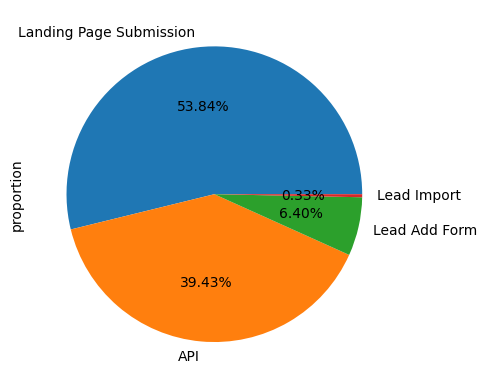

In [583]:
leads["Lead Origin"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.show()

=> The origin identifier mainly is from "Landing Page Submission" and "API"

<Axes: ylabel='proportion'>

Text(0.5, 1.0, 'The proportion of Asymmetrique Activity Index')

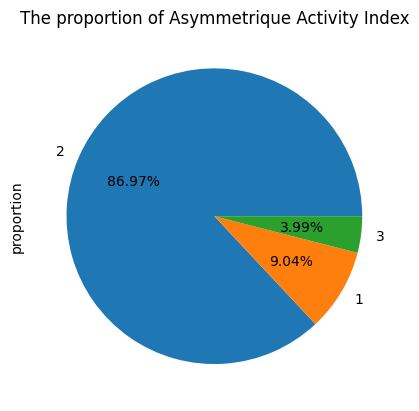

<Axes: ylabel='proportion'>

Text(0.5, 1.0, 'The proportion of Asymmetrique Profile Index')

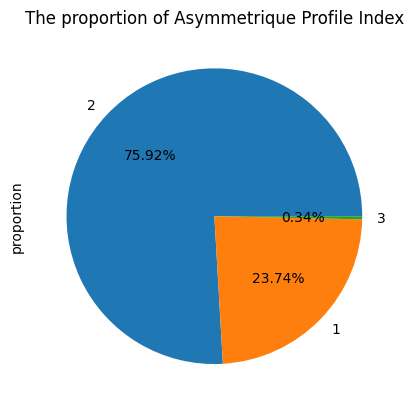

In [584]:
leads["Asymmetrique Activity Index"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.title("The proportion of Asymmetrique Activity Index")
plt.show()
leads["Asymmetrique Profile Index"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.title("The proportion of Asymmetrique Profile Index")
plt.show()

<Axes: ylabel='Lead Source'>

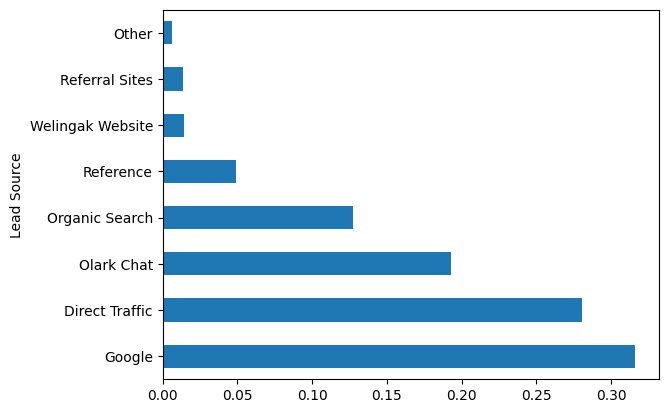

In [585]:
leads["Lead Source"].value_counts(normalize=True).plot.barh()
plt.show()

=> Google accounts for the highest rate among all sources of the lead

<Axes: ylabel='Last Activity'>

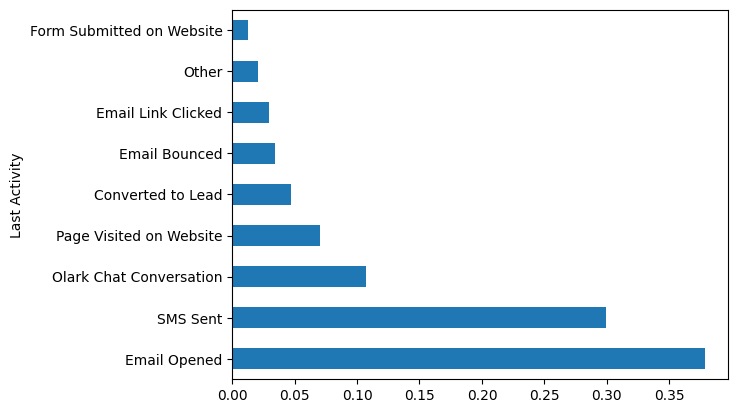

In [586]:
leads["Last Activity"].value_counts(normalize=True).plot.barh()
plt.show()

##### Visualizing the binary columns

<Figure size 2000x1200 with 0 Axes>

<Axes: >

([<matplotlib.patches.Wedge at 0x15158167d10>,
 [Text(-1.0663747211670045, 0.26989804381653754, '0'),
  Text(1.0663747148495846, -0.2698980687768396, '1')],
 [Text(-0.5816589388183661, 0.14721711480902047, '92.1%'),
  Text(0.5816589353725006, -0.14721712842373066, '7.9%')])

Text(0.5, 1.0, 'Do Not Email')

<Axes: >

([<matplotlib.patches.Wedge at 0x15158994bd0>,
 [Text(-1.0999997362718799, 0.0007617097839700848, '0'),
  Text(1.0999997362526923, -0.0007617374925462489, '1')],
 [Text(-0.599999856148298, 0.0004154780639836826, '100.0%'),
  Text(0.599999856137832, -0.0004154931777524993, '0.0%')])

Text(0.5, 1.0, 'Do Not Call')

<Axes: >

([<matplotlib.patches.Wedge at 0x151589f79d0>,
 [Text(-1.0999870783453005, 0.005331742057692539, '0'),
  Text(1.0999870784037997, -0.005331729988760264, '1')],
 [Text(-0.5999929518247094, 0.0029082229405595662, '99.8%'),
  Text(0.5999929518566179, -0.0029082163575055984, '0.2%')])

Text(0.5, 1.0, 'Search')

<Axes: >

([<matplotlib.patches.Wedge at 0x15158a403d0>,
 [Text(-1.0999997362718799, 0.0007617097839700848, '0'),
  Text(1.0999997362526923, -0.0007617374925462489, '1')],
 [Text(-0.599999856148298, 0.0004154780639836826, '100.0%'),
  Text(0.599999856137832, -0.0004154931777524993, '0.0%')])

Text(0.5, 1.0, 'Newspaper Article')

<Axes: >

([<matplotlib.patches.Wedge at 0x151539217d0>,
 [Text(-1.099999934067968, 0.00038085491481262775, '0'),
  Text(1.0999999340631712, -0.0003808687691035126, '1')],
 [Text(-0.5999999640370735, 0.00020773904444325149, '100.0%'),
  Text(0.5999999640344569, -0.00020774660132918867, '0.0%')])

Text(0.5, 1.0, 'X Education Forums')

<Axes: >

([<matplotlib.patches.Wedge at 0x15158ad7010>,
 [Text(-1.099999934067968, 0.00038085491481262775, '0'),
  Text(1.0999999340631712, -0.0003808687691035126, '1')],
 [Text(-0.5999999640370735, 0.00020773904444325149, '100.0%'),
  Text(0.5999999640344569, -0.00020774660132918867, '0.0%')])

Text(0.5, 1.0, 'Newspaper')

<Axes: >

([<matplotlib.patches.Wedge at 0x15158a423d0>,
 [Text(-1.0999989450876455, 0.001523419202695872, '0'),
  Text(1.0999989450108956, -0.001523474619808205, '1')],
 [Text(-0.5999994245932612, 0.0008309559287432029, '100.0%'),
  Text(0.5999994245513974, -0.0008309861562590207, '0.0%')])

Text(0.5, 1.0, 'Digital Advertisement')

<Axes: >

([<matplotlib.patches.Wedge at 0x15158aee890>,
 [Text(-1.0999967693319794, 0.0026659818469803717, '0'),
  Text(1.0999967690969932, -0.0026660788015913654, '1')],
 [Text(-0.5999982378174432, 0.001454171916534748, '99.9%'),
  Text(0.599998237689269, -0.0014542248008680174, '0.1%')])

Text(0.5, 1.0, 'Through Recommendations')

<Axes: >

([<matplotlib.patches.Wedge at 0x15158ba58d0>,
 [Text(-0.5944427177743274, 0.9255473274150119, '0'),
  Text(0.5944427177743278, -0.9255473274150118, '1')],
 [Text(-0.3242414824223604, 0.5048439967718247, '68.2%'),
  Text(0.32424148242236056, -0.5048439967718246, '31.8%')])

Text(0.5, 1.0, 'free_copy_mastering_interview')

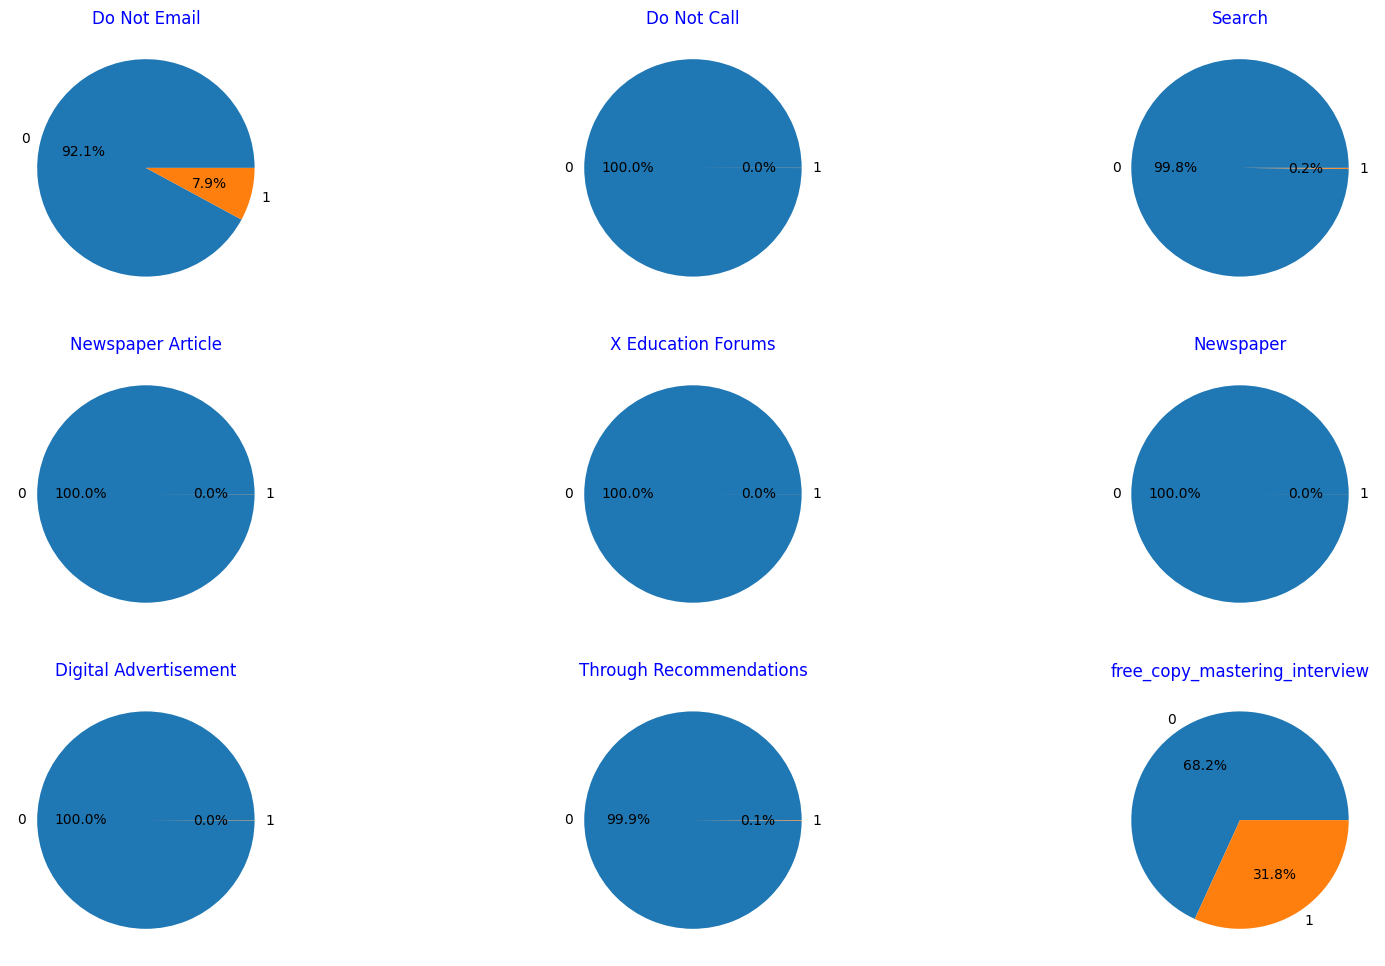

In [587]:
plt.figure(figsize=(20, 12))
for i in range(len(bi_cols)):
    plt.subplot(3,3,i+1)
    counts = leads[bi_cols[i]].value_counts(normalize=True)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title(bi_cols[i], color='blue')
plt.show()

- ALmost customers are okay with receiving emails and calls about the course with over 90% say "No" with "Do not email" or "Do not call" even nearly 100%.
- However, almost advertisement platforms or measurements are not realy effective, because almost 100% customers said "No" about seeing ad before. 
Only in "free_copy_mastering_interview" field, there is 31,8% customers having desire to receive a free copy of 'Mastering the Interview'.

#### 5.2. Bivariate analysis

In [588]:
leads.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'total_time_on_website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'source', 'occupation',
       'course_preference', 'Search', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'Tags', 'Lead Profile', 'City',
       'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'free_copy_mastering_interview', 'Last Notable Activity'],
      dtype='object')

<Axes: xlabel='occupation'>

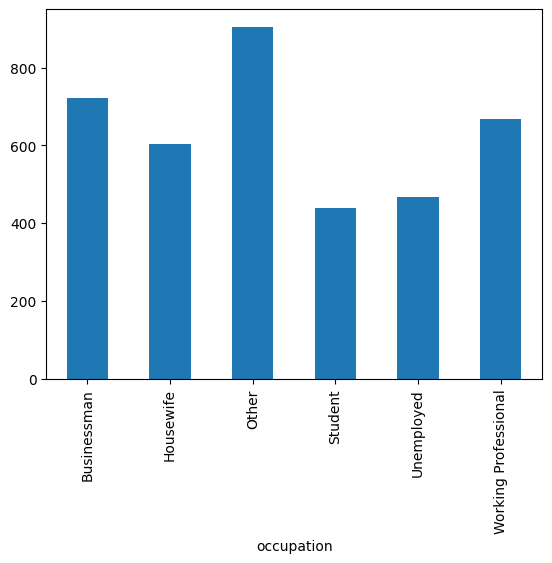

In [589]:
leads.groupby('occupation')["total_time_on_website"].mean().plot.bar()
plt.show()

- People who spent the most time on website are businessman or working Professional. 

=> These groups of people are potential for this course.

<Axes: ylabel='Specialization'>

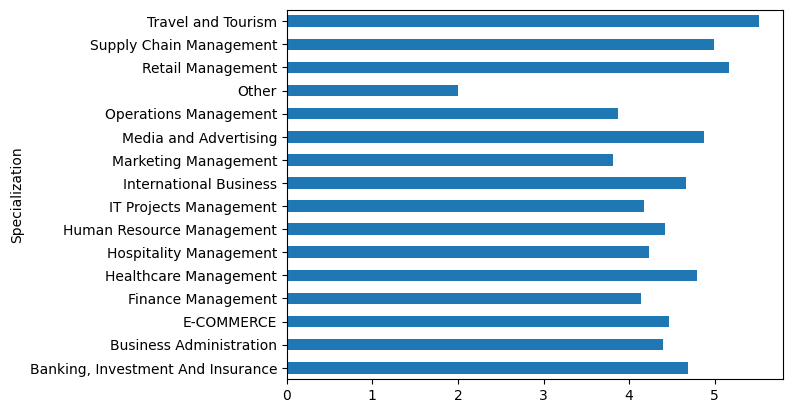

In [590]:
leads.groupby('Specialization')["TotalVisits"].mean().plot.barh()
plt.show()

The customers who worked in "Travel and Tourism", "Supply Chain Management" or "Retail Management" is potential for this course because of their high visits' rate.

<Axes: xlabel='City'>

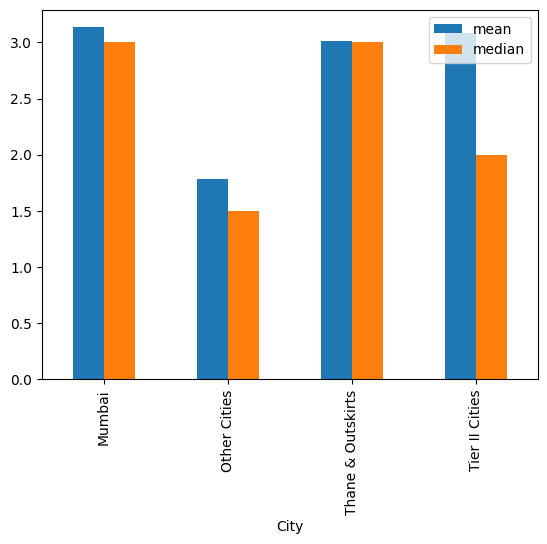

In [591]:
leads.groupby(['City'])['Page Views Per Visit'].aggregate(['mean','median']).plot.bar()
plt.show()

The chart shows the relationship between mean and median values across different city categories:

- Mumbai and Tier II Cities have equal mean and median values, indicating symmetric data distributions.
- Other Cities has a slightly higher mean than median, suggesting a right-skewed distribution.
- Thane & Outskirts also shows similar mean and median values, indicating a symmetric distribution.

#### 5.3. Multivariate analysis

In [592]:
leads.dtypes

Prospect ID                       object
Lead Number                        int64
Lead Origin                       object
Lead Source                       object
Do Not Email                       int32
Do Not Call                        int32
Converted                          int64
TotalVisits                      float64
total_time_on_website              int64
Page Views Per Visit             float64
Last Activity                     object
Country                           object
Specialization                    object
source                            object
occupation                        object
course_preference                 object
Search                             int32
Newspaper Article                  int32
X Education Forums                 int32
Newspaper                          int32
Digital Advertisement              int32
Through Recommendations            int32
Tags                              object
Lead Profile                      object
City            

In [593]:
num_col = []
for i in leads.columns:
    if (leads[i].unique().dtype=="float64" or leads[i].unique().dtype=="int64") and leads[i].unique().size>3:
        num_col.append(i)


In [594]:
num_col

['Lead Number',
 'TotalVisits',
 'total_time_on_website',
 'Page Views Per Visit',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score']

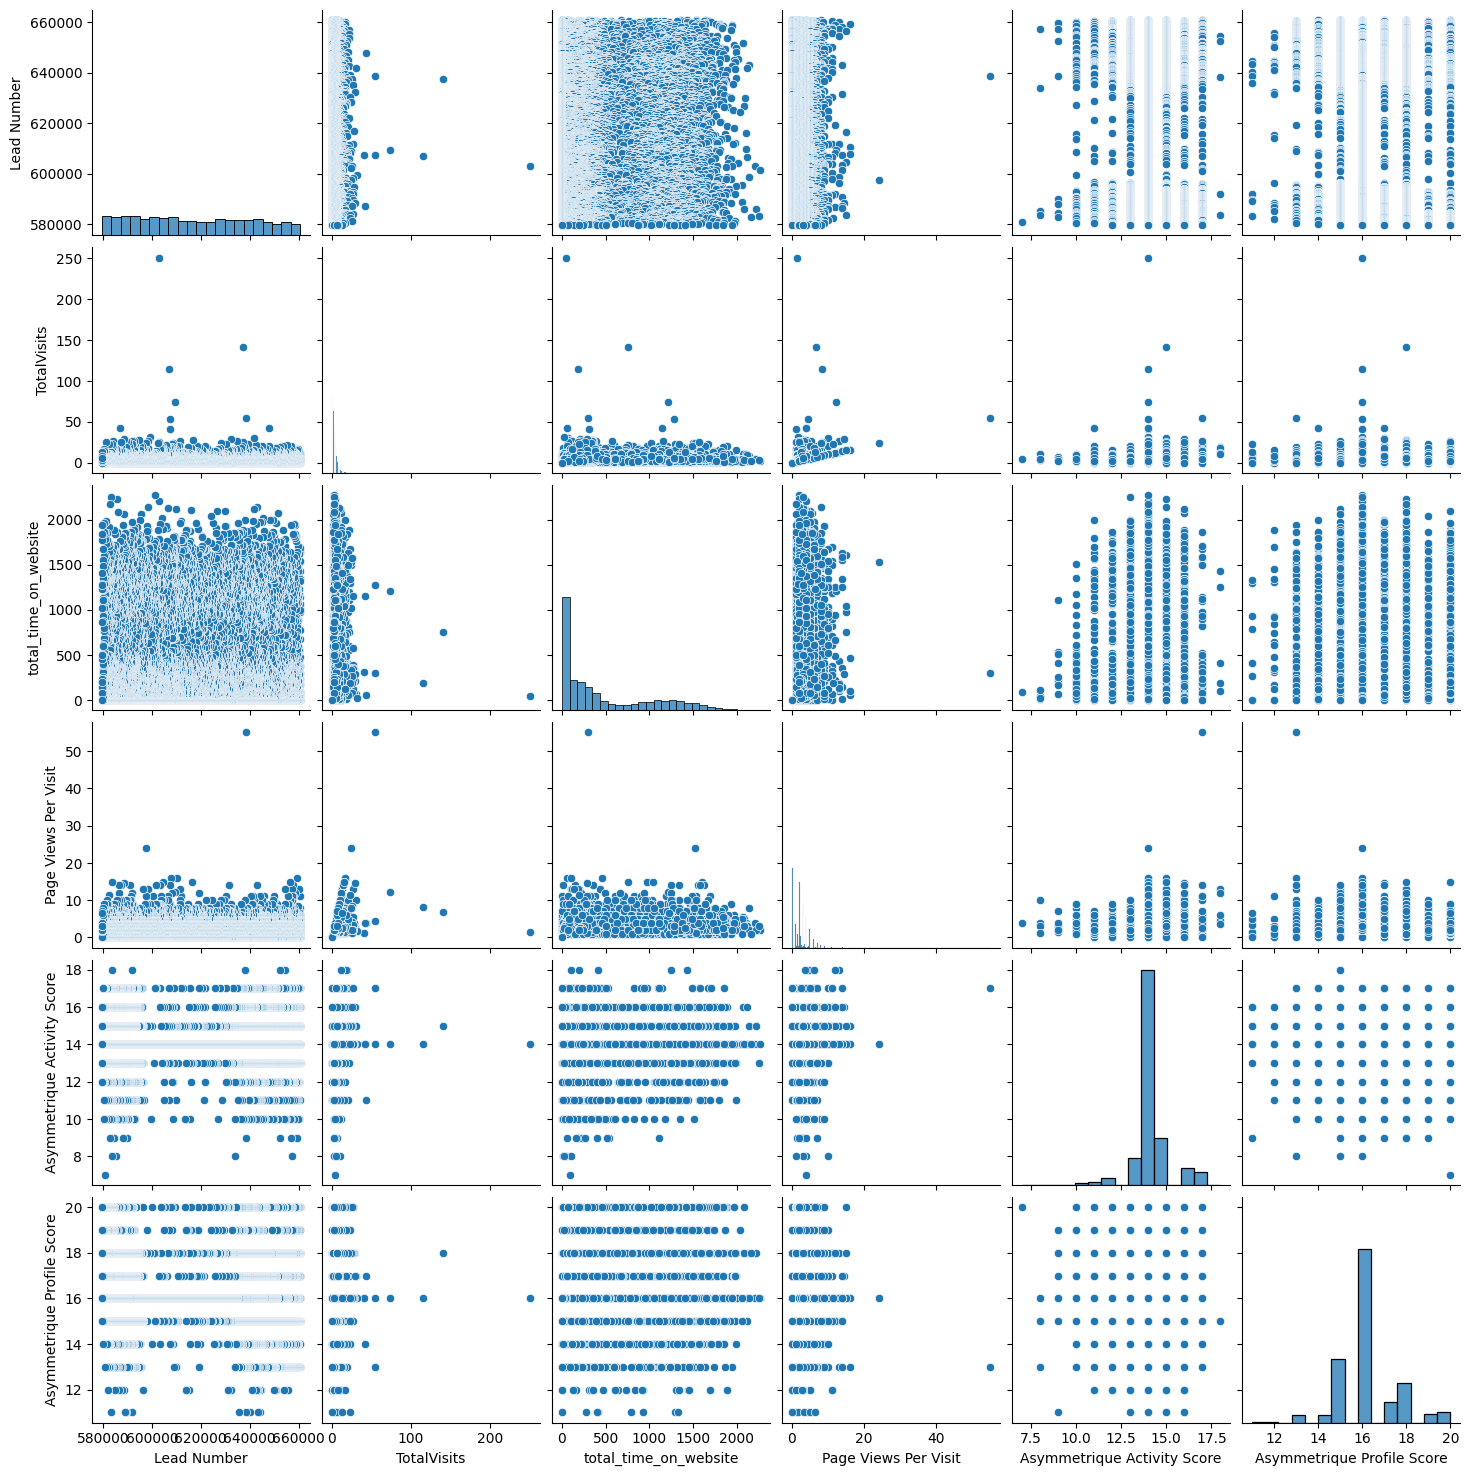

In [595]:
sns.pairplot(leads[num_col])
plt.show()

<Axes: >

Text(0.5, 1.0, 'Correlation between all numerical columns')

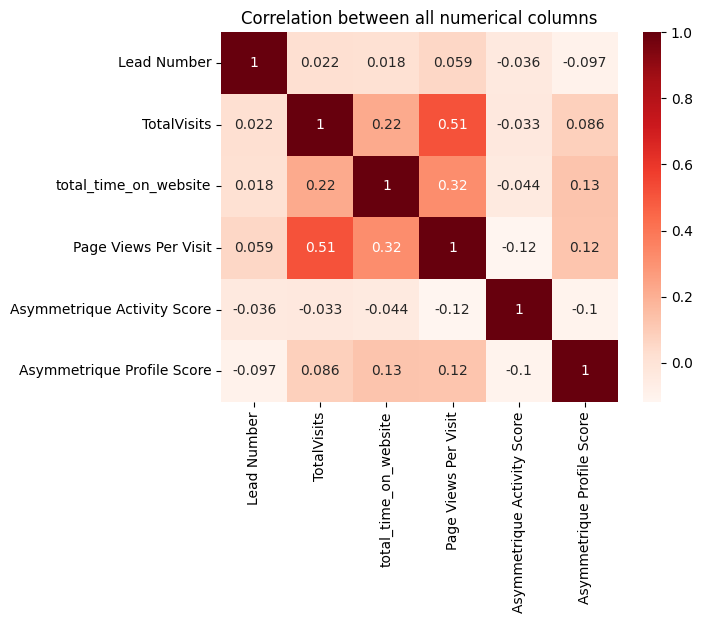

In [596]:
days_corr=leads[num_col].corr()
sns.heatmap(days_corr, annot=True, cmap='Reds')
plt.title("Correlation between all numerical columns")

- Converted shows a moderate positive correlation with total_time_on_website (0.36).
- Converted also has a moderate positive correlation with TotalVisits (0.32).
- TotalVisits and Page Views Per Visit have a moderate positive correlation (0.51).

<Axes: xlabel='City', ylabel='Lead Profile'>

Text(0.5, 1.0, 'Lead Profile vs. City through free_copy_mastering_interview')

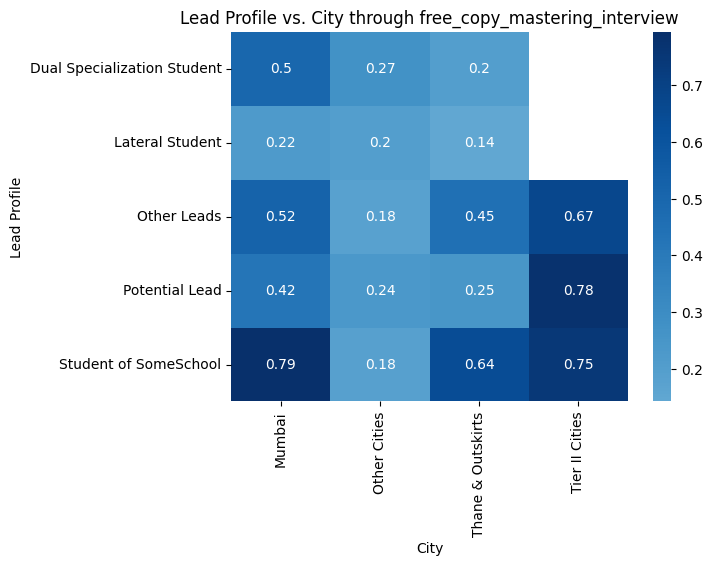

In [597]:
res=pd.pivot_table(data=leads, index="Lead Profile", columns="City", values="free_copy_mastering_interview")
sns.heatmap(res, annot= True, cmap="Blues", center= 0.1)
plt.title("Lead Profile vs. City through free_copy_mastering_interview")
plt.show()

- Student of SomeSchool has high correlations across all city categories, especially in Mumbai (0.79) and Thane & Outskirts (0.64).
- Potential Lead also shows relatively high correlations with Thane & Outskirts (0.78) and Tier II Cities (0.78).

=> This indicates that certain lead profiles, particularly "Student of SomeSchool," are more likely to be associated with receiving a free copy in various city categories.

### 6. Dummy variables

In [598]:
# Dummy columns contains binary columns
dummy_cols = bi_cols

In [599]:
dummy_cols.append("Asymmetrique Activity Index")
dummy_cols.append("Asymmetrique Profile Index")

In [600]:
dummy_cols

['Do Not Email',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'free_copy_mastering_interview',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index']

- When creating dummy variables, the `drop_first=True` parameter is often used to avoid the **dummy variable trap** and to simplify the resulting dataset.

In [601]:
# Get the dummy variables for categorical variables.
status = pd.get_dummies(leads[dummy_cols], columns=dummy_cols, drop_first = True).astype(int)

In [602]:
status.head()

,Do Not Email_1,Do Not Call_1,Search_1,Newspaper Article_1,X Education Forums_1,Newspaper_1,Digital Advertisement_1,Through Recommendations_1,free_copy_mastering_interview_1,Asymmetrique Activity Index_2,Asymmetrique Activity Index_3,Asymmetrique Profile Index_2,Asymmetrique Profile Index_3
0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0


In [603]:
leads = pd.concat([leads, status], axis = 1)

In [604]:
leads.drop(dummy_cols, axis=1, inplace=True)

In [605]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,total_time_on_website,Page Views Per Visit,Last Activity,Country,...,Newspaper Article_1,X Education Forums_1,Newspaper_1,Digital Advertisement_1,Through Recommendations_1,free_copy_mastering_interview_1,Asymmetrique Activity Index_2,Asymmetrique Activity Index_3,Asymmetrique Profile Index_2,Asymmetrique Profile Index_3
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,India,...,0,0,0,0,0,0,1,0,1,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,5.0,674,2.5,Email Opened,India,...,0,0,0,0,0,0,1,0,1,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,India,...,0,0,0,0,0,1,1,0,0,0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Other,India,...,0,0,0,0,0,0,1,0,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,India,...,0,0,0,0,0,0,1,0,0,0


In [606]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9074 entries, 0 to 9239
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Prospect ID                      9074 non-null   object 
 1   Lead Number                      9074 non-null   int64  
 2   Lead Origin                      9074 non-null   object 
 3   Lead Source                      9074 non-null   object 
 4   Converted                        9074 non-null   int64  
 5   TotalVisits                      9074 non-null   float64
 6   total_time_on_website            9074 non-null   int64  
 7   Page Views Per Visit             9074 non-null   float64
 8   Last Activity                    9074 non-null   object 
 9   Country                          9074 non-null   object 
 10  Specialization                   9074 non-null   object 
 11  source                           9074 non-null   object 
 12  occupation               

In [607]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,total_time_on_website,Page Views Per Visit,Last Activity,Country,...,Newspaper Article_1,X Education Forums_1,Newspaper_1,Digital Advertisement_1,Through Recommendations_1,free_copy_mastering_interview_1,Asymmetrique Activity Index_2,Asymmetrique Activity Index_3,Asymmetrique Profile Index_2,Asymmetrique Profile Index_3
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,India,...,0,0,0,0,0,0,1,0,1,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,5.0,674,2.5,Email Opened,India,...,0,0,0,0,0,0,1,0,1,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,India,...,0,0,0,0,0,1,1,0,0,0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Other,India,...,0,0,0,0,0,0,1,0,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,India,...,0,0,0,0,0,0,1,0,0,0


In [608]:
for i in leads.columns:
    leads[i].value_counts()

Prospect ID
7927b2df-8bba-4d29-b9a2-b6e0beafe620    1
5379ee79-64b7-44f8-8c56-0e1ca2d5b887    1
9757ace3-0656-4400-b519-fe0e3c67599e    1
889c1057-97ab-477c-a2b7-423e7df2d226    1
dd5ed9c0-298b-416e-b7e3-ee4da8511b8f    1
                                       ..
bff6c61d-25e3-4b1e-bf17-b634c91f3e2f    1
c62678c1-e741-4874-b5cf-500b2e8e2a78    1
4e859886-6ae2-462b-abd0-1df6ae65d8bf    1
78a9c58c-c287-41e3-a0f5-034061b73343    1
571b5c8e-a5b2-4d57-8574-f2ffb06fdeff    1
Name: count, Length: 9074, dtype: int64

Lead Number
660737    1
602411    1
602438    1
602435    1
602420    1
         ..
630128    1
630135    1
630139    1
630158    1
579533    1
Name: count, Length: 9074, dtype: int64

Lead Origin
Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: count, dtype: int64

Lead Source
Google              2868
Direct Traffic      2543
Olark Chat          1753
Organic Search      1154
Reference            443
Welingak Website     129
Referral Sites       125
Other                 59
Name: count, dtype: int64

Converted
0    5639
1    3435
Name: count, dtype: int64

TotalVisits
0.0      2161
2.0      1679
3.0      1306
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
21.0        6
23.0        6
24.0        5
25.0        5
27.0        5
22.0        3
29.0        2
28.0        2
26.0        2
141.0       1
55.0        1
30.0        1
43.0        1
74.0        1
41.0        1
54.0        1
115.0       1
251.0       1
32.0        1
42.0        1
Name: count, dtype: int64

total_time_on_website
0       2165
60        19
127       18
75        18
74        17
        ... 
609        1
1035       1
802        1
840        1
927        1
Name: count, Length: 1717, dtype: int64

Page Views Per Visit
0.00    2161
2.00    1794
3.00    1196
4.00     896
1.00     651
        ... 
3.43       1
2.56       1
6.33       1
1.64       1
2.08       1
Name: count, Length: 114, dtype: int64

Last Activity
Email Opened                 3432
SMS Sent                     2716
Olark Chat Conversation       972
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 312
Email Link Clicked            267
Other                         191
Form Submitted on Website     116
Name: count, dtype: int64

Country
India                   8787
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malays

Specialization
Other                                3452
Finance Management                    959
Human Resource Management             837
Marketing Management                  823
Operations Management                 499
Business Administration               399
IT Projects Management                366
Supply Chain Management               346
Banking, Investment And Insurance     335
Media and Advertising                 202
Travel and Tourism                    202
International Business                176
Healthcare Management                 156
E-COMMERCE                            111
Hospitality Management                111
Retail Management                     100
Name: count, dtype: int64

source
Other                    7457
Online Search             808
Word Of Mouth             347
Student of SomeSchool     310
Multiple Sources          152
Name: count, dtype: int64

occupation
Unemployed              8159
Working Professional     677
Student                  206
Other                     15
Housewife                  9
Businessman                8
Name: count, dtype: int64

course_preference
Better Career Prospects      9072
Flexibility & Convenience       1
Other                           1
Name: count, dtype: int64

Tags
Will revert after reading the email    5343
Ringing                                1187
Interested in other courses             509
Already a student                       465
Closed by Horizzon                      301
Other                                   300
switched off                            240
Busy                                    185
Lost to EINS                            172
Not doing further education             145
Interested  in full time MBA            116
Graduation in progress                  111
Name: count, dtype: int64

Lead Profile
Other Leads                    7239
Potential Lead                 1554
Student of SomeSchool           240
Lateral Student                  21
Dual Specialization Student      20
Name: count, dtype: int64

City
Other Cities         5078
Mumbai               3177
Thane & Outskirts     745
Tier II Cities         74
Name: count, dtype: int64

Asymmetrique Activity Score
14.0    5857
15.0    1284
13.0     751
16.0     467
17.0     348
12.0     196
11.0      95
10.0      57
9.0        9
18.0       5
8.0        4
7.0        1
Name: count, dtype: int64

Asymmetrique Profile Score
16.0    4736
15.0    1735
18.0    1066
17.0     566
20.0     298
19.0     224
14.0     220
13.0     198
12.0      22
11.0       9
Name: count, dtype: int64

Last Notable Activity
Modified                   3267
Email Opened               2823
SMS Sent                   2152
Page Visited on Website     318
Olark Chat Conversation     183
Email Link Clicked          173
Other                       158
Name: count, dtype: int64

Do Not Email_1
0    8358
1     716
Name: count, dtype: int64

Do Not Call_1
0    9072
1       2
Name: count, dtype: int64

Search_1
0    9060
1      14
Name: count, dtype: int64

Newspaper Article_1
0    9072
1       2
Name: count, dtype: int64

X Education Forums_1
0    9073
1       1
Name: count, dtype: int64

Newspaper_1
0    9073
1       1
Name: count, dtype: int64

Digital Advertisement_1
0    9070
1       4
Name: count, dtype: int64

Through Recommendations_1
0    9067
1       7
Name: count, dtype: int64

free_copy_mastering_interview_1
0    6186
1    2888
Name: count, dtype: int64

Asymmetrique Activity Index_2
1    7892
0    1182
Name: count, dtype: int64

Asymmetrique Activity Index_3
0    8712
1     362
Name: count, dtype: int64

Asymmetrique Profile Index_2
1    6889
0    2185
Name: count, dtype: int64

Asymmetrique Profile Index_3
0    9043
1      31
Name: count, dtype: int64

In [609]:
leads.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source', 'Converted',
       'TotalVisits', 'total_time_on_website', 'Page Views Per Visit',
       'Last Activity', 'Country', 'Specialization', 'source', 'occupation',
       'course_preference', 'Tags', 'Lead Profile', 'City',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'Last Notable Activity', 'Do Not Email_1', 'Do Not Call_1', 'Search_1',
       'Newspaper Article_1', 'X Education Forums_1', 'Newspaper_1',
       'Digital Advertisement_1', 'Through Recommendations_1',
       'free_copy_mastering_interview_1', 'Asymmetrique Activity Index_2',
       'Asymmetrique Activity Index_3', 'Asymmetrique Profile Index_2',
       'Asymmetrique Profile Index_3'],
      dtype='object')

=> These two columns 'Prospect ID', 'Lead Number': all values are unique, so creating dummy variables is not necessary
So I drop both.

In [610]:
leads.drop(['Prospect ID', 'Lead Number'], axis=1, inplace=True)

There are a lot of values in all these columns "Country", "Specialization", "Tags", so creating dummy is not effective for all these columns
=> Dropping all these columns

In [611]:
leads.drop(["Country", "Specialization", "Tags"], axis=1, inplace=True)

In [612]:
# Total Visits
# Group by the binned values
leads['TotalVisits_group'] = pd.cut(leads['TotalVisits'], bins=[0, 10, 30, 100, 300], labels=["Very Low", "Low", "Moderate", "High"])
leads.drop(['TotalVisits'], axis=1, inplace=True)

In [613]:
# total_time_on_website
# Group by the binned values
leads['total_time_group'] = pd.cut(leads['total_time_on_website'], bins=[0, 60, 120, 300, float('inf')], labels=['Very Low', 'Low', 'Moderate', 'High'])
leads.drop(['total_time_on_website'], axis=1, inplace=True)

In [614]:
# Page Views Per Visit
# Group by the binned values
leads['Views_per_visit_group'] = pd.cut(leads["Page Views Per Visit"], bins=[0, 2, 4, 6, float('inf')], labels=['Very Low', 'Low', 'Moderate', 'High'])
leads.drop(["Page Views Per Visit"], axis=1, inplace=True)

In [615]:
# Asymmetrique Activity Score
# Group by the binned values
leads['Asymmetrique Activity Score Group'] = pd.cut(leads["Asymmetrique Activity Score"], bins=[0, 8, 11, 14, float('inf')], labels=['Very Low', 'Low', 'Moderate', 'High'])
leads.drop(["Asymmetrique Activity Score"], axis=1, inplace=True)

In [616]:
# Asymmetrique Profile Score
# Group by the binned values
leads['Asymmetrique Profile Score Group'] = pd.cut(leads["Asymmetrique Profile Score"], bins=[0, 11, 14, 17, float('inf')], labels=['Very Low', 'Low', 'Moderate', 'High'])
leads.drop(["Asymmetrique Profile Score"], axis=1, inplace=True)

In [617]:
for i in leads.columns:
    leads[i].value_counts()

Lead Origin
Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: count, dtype: int64

Lead Source
Google              2868
Direct Traffic      2543
Olark Chat          1753
Organic Search      1154
Reference            443
Welingak Website     129
Referral Sites       125
Other                 59
Name: count, dtype: int64

Converted
0    5639
1    3435
Name: count, dtype: int64

Last Activity
Email Opened                 3432
SMS Sent                     2716
Olark Chat Conversation       972
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 312
Email Link Clicked            267
Other                         191
Form Submitted on Website     116
Name: count, dtype: int64

source
Other                    7457
Online Search             808
Word Of Mouth             347
Student of SomeSchool     310
Multiple Sources          152
Name: count, dtype: int64

occupation
Unemployed              8159
Working Professional     677
Student                  206
Other                     15
Housewife                  9
Businessman                8
Name: count, dtype: int64

course_preference
Better Career Prospects      9072
Flexibility & Convenience       1
Other                           1
Name: count, dtype: int64

Lead Profile
Other Leads                    7239
Potential Lead                 1554
Student of SomeSchool           240
Lateral Student                  21
Dual Specialization Student      20
Name: count, dtype: int64

City
Other Cities         5078
Mumbai               3177
Thane & Outskirts     745
Tier II Cities         74
Name: count, dtype: int64

Last Notable Activity
Modified                   3267
Email Opened               2823
SMS Sent                   2152
Page Visited on Website     318
Olark Chat Conversation     183
Email Link Clicked          173
Other                       158
Name: count, dtype: int64

Do Not Email_1
0    8358
1     716
Name: count, dtype: int64

Do Not Call_1
0    9072
1       2
Name: count, dtype: int64

Search_1
0    9060
1      14
Name: count, dtype: int64

Newspaper Article_1
0    9072
1       2
Name: count, dtype: int64

X Education Forums_1
0    9073
1       1
Name: count, dtype: int64

Newspaper_1
0    9073
1       1
Name: count, dtype: int64

Digital Advertisement_1
0    9070
1       4
Name: count, dtype: int64

Through Recommendations_1
0    9067
1       7
Name: count, dtype: int64

free_copy_mastering_interview_1
0    6186
1    2888
Name: count, dtype: int64

Asymmetrique Activity Index_2
1    7892
0    1182
Name: count, dtype: int64

Asymmetrique Activity Index_3
0    8712
1     362
Name: count, dtype: int64

Asymmetrique Profile Index_2
1    6889
0    2185
Name: count, dtype: int64

Asymmetrique Profile Index_3
0    9043
1      31
Name: count, dtype: int64

TotalVisits_group
Very Low    6560
Low          343
Moderate       7
High           3
Name: count, dtype: int64

total_time_group
High        4086
Moderate    1595
Low          615
Very Low     613
Name: count, dtype: int64

Views_per_visit_group
Very Low    3006
Low         2696
Moderate     851
High         360
Name: count, dtype: int64

Asymmetrique Activity Score Group
Moderate    6804
High        2104
Low          161
Very Low       5
Name: count, dtype: int64

Asymmetrique Profile Score Group
Moderate    7037
High        1588
Low          440
Very Low       9
Name: count, dtype: int64

In [618]:
object_cols = []
for i in leads.columns:
    if leads[i].unique().dtype=="object":
        object_cols.append(i)

In [619]:
object_cols

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'source',
 'occupation',
 'course_preference',
 'Lead Profile',
 'City',
 'Last Notable Activity']

In [620]:
# Get the dummy variables for categorical variables.
status = pd.get_dummies(leads[object_cols], columns=object_cols, drop_first = True).astype(int)

In [621]:
leads = pd.concat([leads, status], axis = 1)
leads.drop(object_cols, axis=1, inplace=True)

In [622]:
leads.head()

,Converted,Do Not Email_1,Do Not Call_1,Search_1,Newspaper Article_1,X Education Forums_1,Newspaper_1,Digital Advertisement_1,Through Recommendations_1,free_copy_mastering_interview_1,...,Lead Profile_Student of SomeSchool,City_Other Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Other,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## *Step 3: Test-train split and scaling*

## *Step 4: Model Building*

**Methods on Model Building:**
- Feature elimination based on correlations
- Feature selection using Recursive Feature Elimination
- Manual feature elimination (using p-values and VIFs)

## *Step 5: Model Evaluation*

**Metrics for Model Evaluation:**
- Accuracy
- Sensitivity and Specificity
- Optimal cut-off using ROC curve
- Precision and Recall

## *Step 6: Predictions on the test set*